In [240]:
import os

In [241]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml\\AI-powered-Bank-Product-Recommender-Chatbot'

In [242]:
os.chdir("../.")

In [243]:
%pwd

'C:\\Users\\RICH-FILES\\Desktop\\ml'

In [244]:
project_dir = "C:/Users/RICH-FILES/Desktop/ml/AI-powered-Bank-Product-Recommender-Chatbot"
os.chdir(project_dir)

In [245]:

from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class FinalModelConfig: 
    """Configuration for the final model"""
    
    training_data: Path
    testing_data: Path
    final_model: Path
    target_column: str
    penalty: str
    C: float
    solver: str
    max_iter: int
    random_state: int
    class_weight: str
    n_jobs: int
    model_encoder: Path
    metric_file: Path
    
    

In [246]:
from BankProducts.constants import *
from BankProducts.utils.common import read_yaml, create_directories


In [247]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,    
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH,
        ):
       
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)        
    
        create_directories([self.config.artifacts_root])
        
    def get_final_model_config(self)-> FinalModelConfig:
        """Returns the final model configuration."""
        config = self.config.retrained_model
        params = self.params.logistic_regression
        schema = self.schema.target_column
        
        create_directories([self.config.artifacts_root])
        
        final_model_config = FinalModelConfig(
          
           target_column=schema.name,
           training_data= Path(config.training_data),
           testing_data= Path(config.testing_data),
           final_model= Path(config.final_model),
           penalty= params.penalty,
           C= params.C,
           max_iter= params.max_iter,
           random_state= params.random_state,
           solver= params.solver,
           n_jobs= params.n_jobs,
           model_encoder= Path(config.model_encoder),
           class_weight= params.class_weight,
           metric_file= Path(config.metric_file)
           
           
           
                         
            
        )
        
        
        
        return final_model_config   
        

In [248]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from BankProducts import logger
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from urllib.parse import urlparse
import tempfile
from BankProducts.utils.common import save_json
import os 


In [249]:
class FinalModel:
    def __init__(self, config: FinalModelConfig):
        self.config = config
        
    def final_training(self):
        #make sure the path exists
        os.makedirs(os.path.dirname(self.config.training_data), exist_ok=True)
        
        df = pd.read_csv(self.config.training_data)
        
        # Correct column selection using a list
        data = df[["monthlyincome", "productcategory", "most_used_channel", 
                   "productsubcategory", "amount", "recommendedoffer"]]
        
        # Drop target column to get training features
        X_train = data.drop(columns=[self.config.target_column])
        Y_train = data[self.config.target_column]
        
        print(data.head())
        print(X_train.head())
        
        print(Y_train.head())
        
        # apply Label Encoder to categorical variables
        le = LabelEncoder()
        Y_train = le.fit_transform(Y_train)
        
        # make sure the path exists
        os.makedirs(os.path.dirname(self.config.model_encoder), exist_ok=True)
        # save the Label Encoder  using joblib
        joblib.dump(le, self.config.model_encoder)
        
        
        
        # apply OneHot Encoder to categorical variables and scale numerical variables 
        categorical_cols = X_train.select_dtypes(include=['object']).columns
        numerical_cols = X_train.select_dtypes(include=['int64']).columns
        #print(categorical_cols)
        #print(numerical_cols)
        
        # define the Logistic Regression model 
        model = LogisticRegression( C= self.config.C,
                                   penalty = self.config.penalty,
                                   solver = self.config.solver,
                                   max_iter = self.config.max_iter,
                                   random_state = self.config.random_state,
                                   n_jobs= self.config.n_jobs
                                   )
        
        # Create the ColumnTransformer and  pipeline combining preprocessing, scaling, and modeling
        preprocessor = ColumnTransformer( transformers = [
            ('num', StandardScaler(), numerical_cols),  
            ('cat', OneHotEncoder(handle_unknown= 'ignore', sparse_output= False), categorical_cols)  
            ],
                                         remainder='passthrough',
                                         n_jobs = self.config.n_jobs        
                                         )
        
        # create the pipeline
        pipeline = Pipeline(steps = [
            ('preprocessor', preprocessor),
            ('model', model)
            ]   
        )
        
        # fit the pipeline to the training data
        pipeline.fit(X_train, Y_train)  
        
        # make sure the path exists
        os.makedirs(os.path.dirname(self.config.final_model), exist_ok=True)
        
        # save the pipeline using joblib
        joblib.dump(pipeline, self.config.final_model)
        
        return data, X_train, Y_train
    
    #def model_evaluation(self):
        
    def eval_metrics(self, actual, pred):
        accuracy = accuracy_score(actual, pred)
        precision = precision_score(actual, pred, average='weighted')
        recall = recall_score(actual, pred, average='weighted')
        f1 = f1_score(actual, pred, average='weighted')
        return accuracy, precision, recall, f1

    def log_confusion_matrix(self, actual, predicted, class_names):
        cm = confusion_matrix(actual, predicted)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        temp_img_path = tempfile.NamedTemporaryFile(suffix=".png", delete=False).name
        plt.savefig(temp_img_path)
        plt.close()
        mlflow.log_artifact(temp_img_path, artifact_path="confusion_matrix")

    def log_classification_report(self, actual, predicted, class_names):
        report = classification_report(actual, predicted, target_names=class_names)
        temp_txt_path = tempfile.NamedTemporaryFile(suffix=".txt", delete=False).name
        with open(temp_txt_path, "w") as f:
            f.write(report)
        mlflow.log_artifact(temp_txt_path, artifact_path="bank_products_recommender")

    def log_into_mlflow(self):
        
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        mlflow.set_experiment("Product Recommender")

        if mlflow.active_run():
            mlflow.end_run()

        with mlflow.start_run():
            #load the model and the data
            #make sure the path exists
            os.makedirs(os.path.dirname(self.config.testing_data), exist_ok=True)
            
            test_df = pd.read_csv(self.config.testing_data)
            
            # Correct column selection using a list
            data = test_df[["monthlyincome", "productcategory", "most_used_channel", 
                    "productsubcategory", "amount", "recommendedoffer"]]
            
            
            X_test = data.drop(columns=self.config.target_column)
            Y_test = data[self.config.target_column]
            
            print(data.head())
            print(X_test.head())
            
            print(Y_test.head())
            
            # Encode the target variable
            le = joblib.load(self.config.model_encoder)
            test_y_encoded = le.transform(Y_test)
            
            # load the model
            pipeline = joblib.load(self.config.final_model)
            predicted = pipeline.predict(X_test)

            accuracy, precision, recall, f1 = self.eval_metrics(test_y_encoded, predicted)
            
             # evaluate the model
            rf_report = classification_report(test_y_encoded, predicted)
            rf_cm = confusion_matrix(test_y_encoded, predicted)   
            rf_accuracy = accuracy_score(test_y_encoded, predicted)   
            
            #create Confusion Matrix Display
            plt.figure(figsize=(15, 7))
            ax = plt.gca()

            cm_display = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=le.classes_)

            cm_display.plot(ax=ax)

            plt.title("Classifier Matrix")

            # Rotate x-axis labels to 45 degrees for better readability
            plt.xticks(rotation=45, ha='right')  

            # Rotate y-axis labels to 0 degrees (horizontal) for clarity
            plt.yticks(rotation=0)

            plt.tight_layout()  # Adjust layout to fit everything nicely

            plt.show()

            
            

            logger.info(f"Classification Report:\n{rf_report}")
            logger.info(f"Confusion Matrix:\n{rf_cm}") 
            logger.info(f"sAccuracy: {rf_accuracy}")
            

            scores = {
                "model_name": "logistic_classifier",
                "accuracy": accuracy,
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }
            
            # Ensure directory exists
            Path(self.config.metric_file).parent.mkdir(parents=True, exist_ok=True)

            save_json(Path(self.config.metric_file), data=scores)
            
            logger.info("Metrics saved to: %s", self.config.metric_file)
            
            logger.info("Logging accuracy")
            mlflow.log_metric("accuracy", accuracy)

            logger.info("Logging precision")
            mlflow.log_metric("precision", precision)

            logger.info("Logging recall")
            mlflow.log_metric("recall", recall)

            logger.info("Logging f1_score")
            mlflow.log_metric("f1_score", f1)

            logger.info("Setting class_names")
            class_names = le.classes_

            logger.info("Logging confusion matrix")
            self.log_confusion_matrix(test_y_encoded, predicted, class_names)

            logger.info("Logging classification report")
            self.log_classification_report(test_y_encoded, predicted, class_names)
            
            
            logger.info("Tracking URI scheme: %s", tracking_url_type_store)
            logger.info("Tracking URI: %s", mlflow.get_tracking_uri())


            #if tracking_url_type_store != "file":
                #mlflow.sklearn.log_model(pipeline, "pipeline", registered_model_name="product recommender")
            #else:
                #mlflow.sklearn.log_model(pipeline, "pipeline")
              
            logger.info("mlflow model logged successfully.")
            
            return accuracy, precision, recall, f1, scores, class_names, 
        
        
        
        
        
        
        
        
        
        
        
        
        


[2025-06-14 15:26:22,501: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-06-14 15:26:22,509: INFO: common: yaml file: params.yaml loaded successfully]
[2025-06-14 15:26:22,516: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-06-14 15:26:22,518: INFO: common: created directory at: artifacts]
[2025-06-14 15:26:22,520: INFO: common: created directory at: artifacts]
   monthlyincome  productcategory most_used_channel productsubcategory  \
0        8980.42         Mortgage            Branch            Student   
1        7462.95         Mortgage               ATM           Platinum   
2        6662.14  Savings Account            Branch           Business   
3        2570.82  Savings Account               ATM           Business   
4        8584.25             Loan            Mobile           Business   

         amount             recommendedoffer  
0  12075.266419   Exclusive Platinum Package  
1   7972.298175   Exclusive Platinum Package  
2   3821.

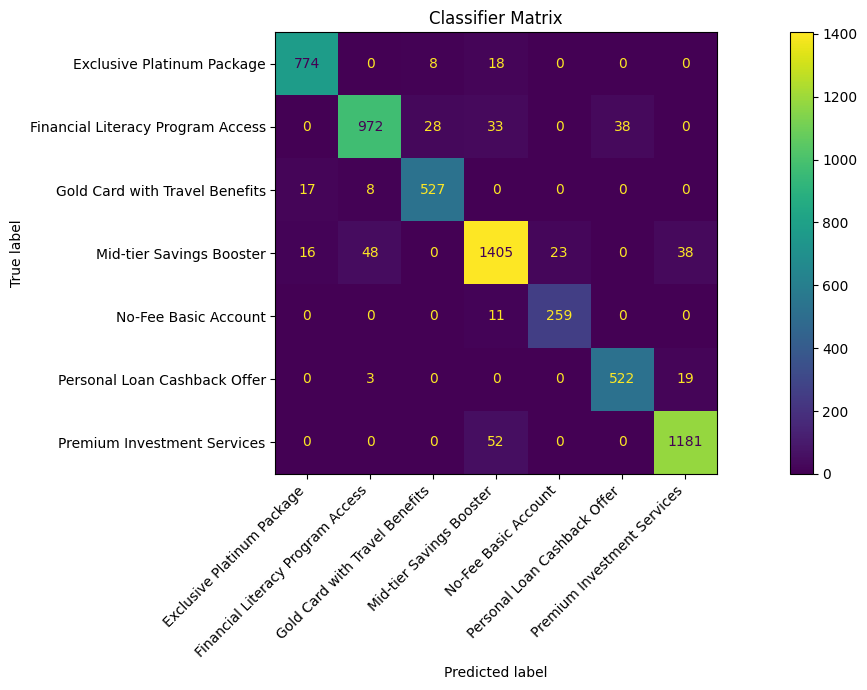

[2025-06-14 15:26:24,124: INFO: 2612459457: Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       800
           1       0.94      0.91      0.92      1071
           2       0.94      0.95      0.95       552
           3       0.92      0.92      0.92      1530
           4       0.92      0.96      0.94       270
           5       0.93      0.96      0.95       544
           6       0.95      0.96      0.96      1233

    accuracy                           0.94      6000
   macro avg       0.94      0.95      0.94      6000
weighted avg       0.94      0.94      0.94      6000
]
[2025-06-14 15:26:24,126: INFO: 2612459457: Confusion Matrix:
[[ 774    0    8   18    0    0    0]
 [   0  972   28   33    0   38    0]
 [  17    8  527    0    0    0    0]
 [  16   48    0 1405   23    0   38]
 [   0    0    0   11  259    0    0]
 [   0    3    0    0    0  522   19]
 [   0    0    0   52    0    0 1181]]]
[2025

In [250]:
try:
    config = ConfigurationManager()
    final_model_config = config.get_final_model_config()
    fin_model = FinalModel(config = final_model_config)

    fin_model.final_training()
    fin_model.log_into_mlflow()
    
except Exception as e:
    logger.exception(f"An error occurred: {e}")
    raise e 
